## [Our DDSP project in Github](https://github.com/XinjianOUYANG/Pole_Projet_DDSP)

# DDSP synthesizer

Evaluate the generation quality of the DDSP synthesizer using the GMM from T3.2 and predefined pitch and loudness profiles.

####  Expected outcome of T3: 
A fully generative model based on DDSP which can generate musical sounds without any input audio signal

## Install Dependencies

In [1]:
# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds 
import ddsp
import utils
import os
import gin
import pickle
import matplotlib
import IPython.display as ipd
import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import librosa.display
 
%matplotlib inline
sample_rate = 16000

## Set the path of audio and model

In [2]:
# audio path
audio_path = 'Datasets/Piano/Audio/Piano_01.wav'

**the model trained with z encoder**

In [3]:
# model folder direction 
model_dir_z = 'Pretrained_Models_for_T2/piano_ae'
# dataset_statistics.pkl in .model folder
dataset_stats_file_z = os.path.join(model_dir_z, 'dataset_statistics.pkl')
# operative_config-0.gin in model folder
gin_file_z = os.path.join(model_dir_z, 'operative_config-0.gin')

**the model trained without z encoder**

In [4]:
# model folder direction 
model_dir = 'Pretrained_Models_for_T2/sax_solo'
# dataset_statistics.pkl in .model folder
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
# operative_config-0.gin in model folder
gin_file = os.path.join(model_dir, 'operative_config-0.gin')

## Read audios and computing (f0,loudness,MFCC)

### Use the given python file [spectral_ops.py](https://github.com/magenta/ddsp/blob/master/ddsp/spectral_ops.py) in ddsp library to compute $f0$ and loudness.
* *ddsp.spectral_ops.compute_f0*

* *ddsp.spectral_ops.compute_loudness*

In [5]:
print(audio_path)
x_all, sr = sf.read(audio_path) #data,samplerate
print('shape of original signal:',np.shape(x_all),'\n','original sample rate:',sr)
sig = x_all[:] # choose the first channel of the original audio
 
# resample (down sampling to 16kHz) and take the 10-20 seconds
sig_re = librosa.resample(sig,sr,sample_rate)
audio = sig_re[10*sample_rate:20*sample_rate]
print('audio shape:',np.shape(audio))
audio = audio[np.newaxis,:]

# # plot wave form
# T_all = audio.shape[1]
# time = np.arange(T_all)/sample_rate
# plt.figure(figsize=(9,3))
# plt.plot(time, audio[0])
# plt.xlabel('time (s)')
# plt.ylabel('amplitude')

# # Calculate Spectrogram and plot
# utils.specplot(audio)

Datasets/Piano/Audio/Piano_01.wav
shape of original signal: (960000,) 
 original sample rate: 16000
audio shape: (160000,)


In [6]:
# play audio
ipd.Audio(audio[0], rate = sample_rate)

In [22]:
#extracting f0 with CREPE
ddsp.spectral_ops.reset_crepe()
f0_crepe, f0_confidence = ddsp.spectral_ops.compute_f0(audio[0], 
                                                       sample_rate= sample_rate,
                                                       frame_rate=100,
                                                       viterbi=False)
#extracting loudness 
loudness =ddsp.spectral_ops.compute_loudness(audio[0],
                     sample_rate= sample_rate,
                     frame_rate=250,
                     n_fft=2048,
                     ref_db=20.7,
                     use_tf=False)

# audio_features dictionary
audio_features_key = ['audio','f0_hz','f0_confidence','loudness_db']
audio_features = dict([(k,[]) for k in audio_features_key])
audio_features['audio'] = audio
audio_features['f0_hz'] = f0_crepe
audio_features['f0_confidence'] = f0_confidence
audio_features['loudness_db'] = loudness

# # Plot Pitch/f0.
# plt.figure(figsize=(6, 4))
# f0_crepe_midi = ddsp.core.hz_to_midi(f0_crepe)
# plt.plot(np.ravel(f0_crepe), label='crepe')
# plt.ylabel('Pitch (MIDI)')
# # Plot f0_confidence.
# plt.figure(figsize=(6, 4))
# plt.plot(np.ravel(f0_confidence), label='f0 confidence')
# plt.ylabel('f0 confidence')
# # Plot Loundness.
# plt.figure(figsize=(6, 4))
# plt.plot(np.ravel(loudness), label='loudness')
# plt.ylabel('Loudness')

## Load the model

In [23]:
def model_loading(model_dir,dataset_stats_file,gin_file,audio_features,audio):
    # Load the dataset statistics.
    print(f'Loading dataset statistics from {dataset_stats_file}')
    try:
      if tf.io.gfile.exists(dataset_stats_file):
        with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
          DATASET_STATS = pickle.load(f)
    except Exception as err:
      print('Loading dataset statistics from pickle failed: {}.'.format(err))


    # Parse gin config,
    with gin.unlock_config():
      gin.parse_config_file(gin_file, skip_unknown=True)

    # Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
    ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
    ckpt_name = ckpt_files[0].split('.')[0]
    ckpt = os.path.join(model_dir, ckpt_name)

    # Ensure dimensions and sampling rates are equal
    time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
    n_samples_train = gin.query_parameter('Harmonic.n_samples')
    hop_size = int(n_samples_train / time_steps_train)

    time_steps = int(audio.shape[1] / hop_size)
    n_samples = time_steps * hop_size

    # print("===Trained model===")
    # print("Time Steps", time_steps_train)
    # print("Samples", n_samples_train)
    # print("Hop Size", hop_size)
    # print("\n===Resynthesis===")
    # print("Time Steps", time_steps)
    # print("Samples", n_samples)
    # print('')

    gin_params = [
        'Harmonic.n_samples = {}'.format(n_samples),
        'FilteredNoise.n_samples = {}'.format(n_samples),
        'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
        'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
    ]

    with gin.unlock_config():
      gin.parse_config(gin_params)

    # Trim all input vectors to correct lengths 
    for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
      audio_features[key] = audio_features[key][:time_steps]
    audio_features['audio'] = audio_features['audio'][:n_samples]

    # Set up the model just to predict audio given new conditioning
    model = ddsp.training.models.Autoencoder()
    model.restore(ckpt)
    # Resynthesize audio.
    outputs = model(audio_features, training=False) # Run the forward pass, add losses, and create a dictionary of outputs.
    audio_gen = outputs['audio_synth']
    
    return audio_gen, outputs, model

In [24]:
# load the model without z encoder
print(model_dir,'\n',dataset_stats_file,'\n',gin_file)
audio_gen, outputs, model = model_loading(model_dir,dataset_stats_file,gin_file,audio_features,audio)

Pretrained_Models_for_T2/sax_solo 
 Pretrained_Models_for_T2/sax_solo/dataset_statistics.pkl 
 Pretrained_Models_for_T2/sax_solo/operative_config-0.gin
Loading dataset statistics from Pretrained_Models_for_T2/sax_solo/dataset_statistics.pkl
Loading dataset statistics from pickle failed: No module named 'google.colab'.


In [25]:
# load the model with z encoder
print(model_dir_z,'\n',dataset_stats_file_z,'\n',gin_file_z)
audio_gen_z, outputs_z, model_z = model_loading(model_dir_z,dataset_stats_file_z,gin_file_z,audio_features,audio)

Pretrained_Models_for_T2/piano_ae 
 Pretrained_Models_for_T2/piano_ae/dataset_statistics.pkl 
 Pretrained_Models_for_T2/piano_ae/operative_config-0.gin
Loading dataset statistics from Pretrained_Models_for_T2/piano_ae/dataset_statistics.pkl


### Extract feature z from the model

In [26]:
z_feature = outputs_z['z']

print(outputs_z.keys())
print('\n shape of z:',np.shape(z_feature),'\n')
print(np.shape(audio_features['f0_hz']), np.shape(outputs_z['f0_hz']))
print(np.shape(audio_features['loudness_db']), np.shape(outputs_z['loudness_db']))

# print(audio_features['f0_hz'],outputs_z['f0_hz'],audio_features['loudness_db'],outputs_z['loudness_db'][0])
# print('\n',outputs_z['inputs'].keys())

dict_keys(['inputs', 'audio', 'f0_hz', 'f0_confidence', 'loudness_db', 'f0_scaled', 'ld_scaled', 'z', 'amps', 'harmonic_distribution', 'noise_magnitudes', 'harmonic', 'filtered_noise', 'add', 'out', 'audio_synth'])

 shape of z: (1, 2500, 16) 

(1000,) (1, 2500, 1)
(2500,) (1, 2500, 1)


# Synthesize pitch, loudness and z features

#### References
* [autoencoder.py](https://github.com/magenta/ddsp/blob/master/ddsp/training/models/autoencoder.py)
* [Scale f0, ld](https://github.com/magenta/ddsp/blob/master/ddsp/training/preprocessing.py)
* [processor_group](https://github.com/magenta/ddsp/blob/d9124662d4e836a7665039f98e7421b9dd9a4178/ddsp/processors.py#L81)

In [27]:
f0_scaled = outputs_z['f0_scaled']
ld_scaled = outputs_z['ld_scaled']

print('\n', np.size(f0_scaled),np.size(ld_scaled))

# print(f0_scaled,'\n',audio_features['f0_hz'])
# print(ld_scaled,'\n',audio_features['loudness_db'])


 2500 2500


### GMM over z

In [28]:
import sklearn
from sklearn.mixture import GaussianMixture

load_path = 'z_datasets/z_piano_ae.npy'

X = np.load(load_path)
# X = np.zeros(shape=(1,1,15000,16))
# X[0] = np.load(load_path)[0]
print(np.shape(X))

# reduce dimensionality 
N, T_step, Z_dim = np.shape(X)[0], np.shape(X)[2], np.shape(X)[3]
X_new = np.zeros(shape=(N,T_step, Z_dim))

for i in np.arange(N):
    X_new[i] = X[i,0]
    
print(np.shape(X_new))

X_re = np.reshape(X_new,(N*T_step,16))
print(np.shape(X_re))

# fit Z and build a GMM model
gm = GaussianMixture(n_components=10).fit(X_re)

(15, 1, 15000, 16)
(15, 15000, 16)
(225000, 16)


In [29]:
# Predict Z
Z_frames = 2500

predictions = gm.sample(Z_frames)
Z = np.zeros(shape=(1,Z_frames, 16))
Z[0] = predictions[0]

print(np.shape(Z))

# only one value of z 
# fix one value, constant pitch and loudness
# sample from only on of the GM. inverse transform sampling, move smoothly
# Presentation: whole project + personal contributions in one slide at the end. 15 mins presentation and 5 mins questions.

(1, 2500, 16)


## Synthesizing 

In [30]:
inputs_keys = ['ld_scaled', 'f0_scaled', 'z','f0_hz']
inputs = dict([(k,[]) for k in inputs_keys])

inputs['ld_scaled'] = ld_scaled # f0_scaled = outputs_z['f0_scaled']
inputs['f0_scaled'] = f0_scaled # ld_scaled = outputs_z['ld_scaled']
inputs['z'] = Z
inputs['f0_hz'] = outputs_z['f0_hz']

In [31]:
# input_keys=('ld_scaled', 'f0_scaled', 'z')
# 'model_z' is the pretrained model with z encoder
pg_out = model_z.decode(inputs,training = False) # pg = processor group
audio_syn = pg_out

In [32]:
ipd.Audio(audio_syn, rate = sample_rate)

## Comparing the results

In [33]:
print('Original')
ipd.Audio(audio, rate = sample_rate) 

Original


In [34]:
print('Resynthesis without z encoder')
ipd.Audio(audio_gen, rate = sample_rate)

Resynthesis without z encoder


In [35]:
print('Resynthesis with z encoder')
ipd.Audio(audio_gen_z, rate = sample_rate)

Resynthesis with z encoder


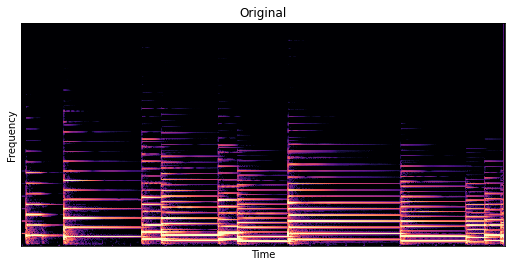

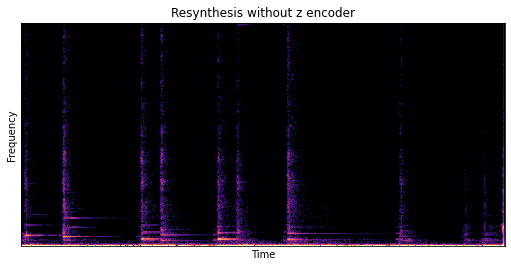

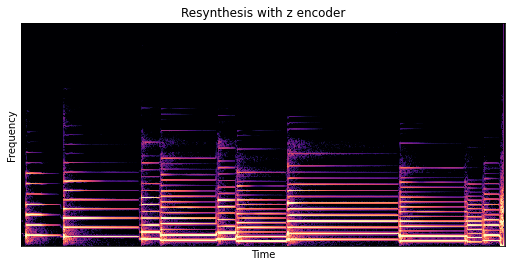

In [36]:
# Plot
utils.specplot(audio)
plt.title("Original")

utils.specplot(audio_gen)
_ = plt.title("Resynthesis without z encoder")

utils.specplot(audio_gen_z)
_ = plt.title("Resynthesis with z encoder")